In [7]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import math
import random
from scipy.spatial import KDTree
import open3d as o3d

In [ ]:
def find_line_intersections(lines):
    intersections = []
    for i in range(len(lines)):
        for j in range(i + 1, len(lines)):
            rho1, theta1 = lines[i][0]
            rho2, theta2 = lines[j][0]
            A = np.array([
                [np.cos(theta1), np.sin(theta1)],
                [np.cos(theta2), np.sin(theta2)]
            ])
            b = np.array([rho1, rho2])
            if np.linalg.det(A) != 0:  # Avoid parallel lines
                intersection = np.linalg.solve(A, b)
                intersections.append(intersection)
    return np.array(intersections)

In [ ]:
def icp(A, B, max_iterations=100, tolerance=1e-6):
    prev_error = 0
    for i in range(max_iterations):
        tree = KDTree(B)
        distances, indices = tree.query(A)
        matched_points = B[indices]

        H = np.dot((A - A.mean(axis=0)).T, matched_points - matched_points.mean(axis=0))
        U, S, Vt = np.linalg.svd(H)
        R = np.dot(U, Vt)
        t = matched_points.mean(axis=0) - np.dot(A.mean(axis=0), R)

        A = np.dot(A, R) + t

        mean_error = np.mean(distances)
        if abs(prev_error - mean_error) < tolerance:
            break
        prev_error = mean_error

    return R, t, A


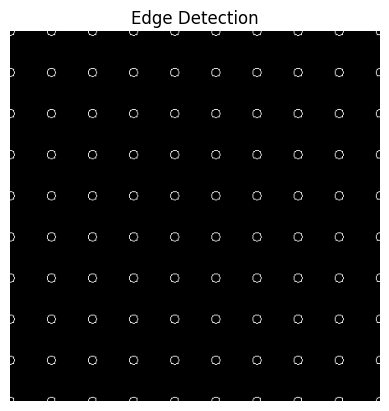

C:\Users\danim\AppData\Local\Temp\ipykernel_25180\1795969238.py:17: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  corners = np.int0(corners).reshape(-1, 2)


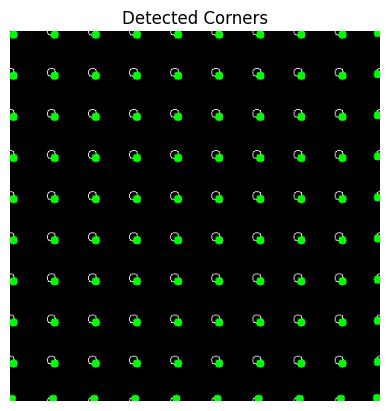

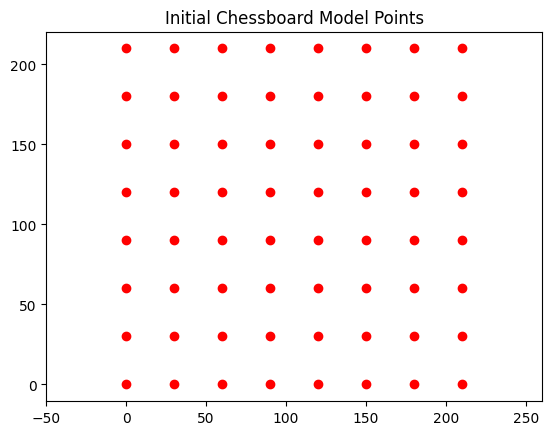

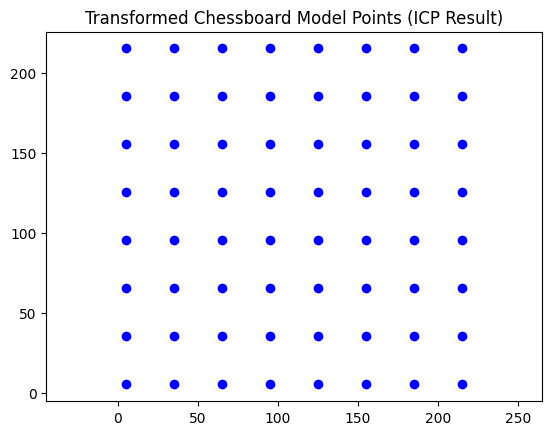

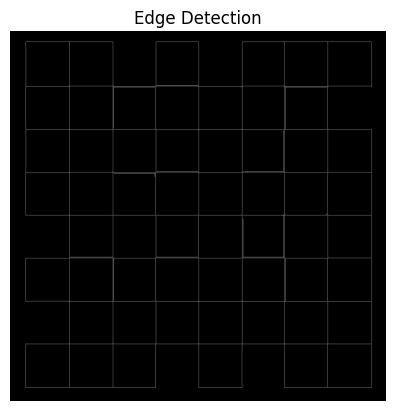

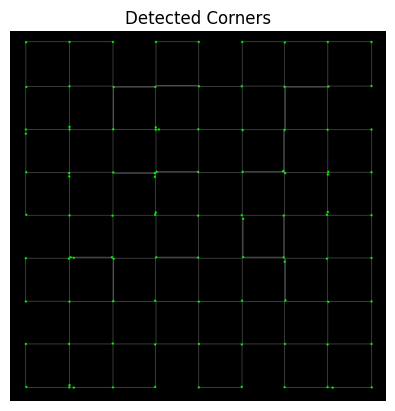

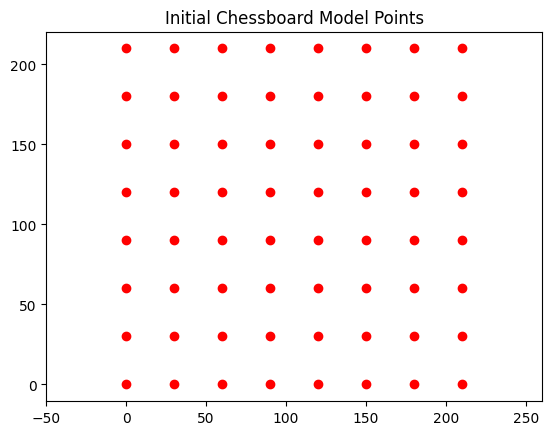

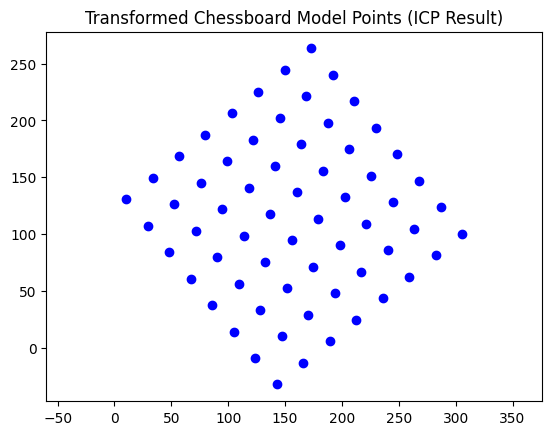

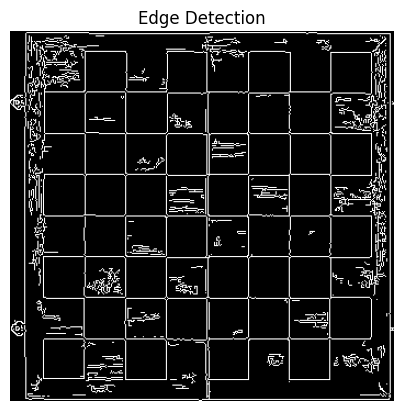

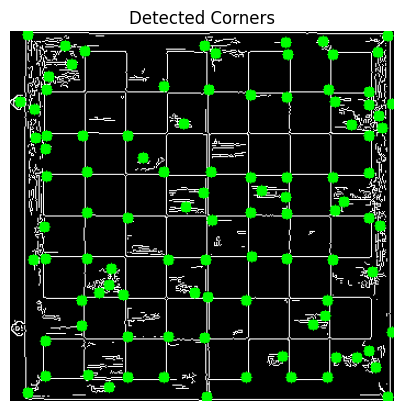

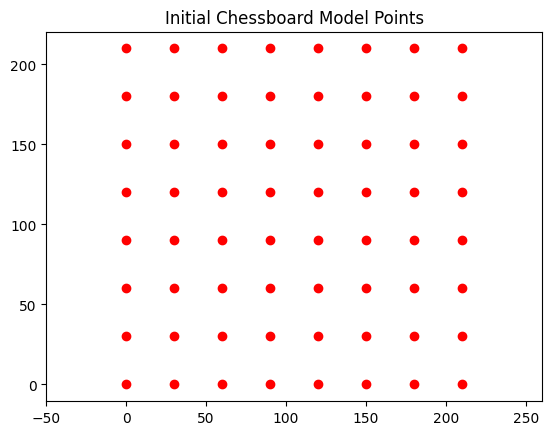

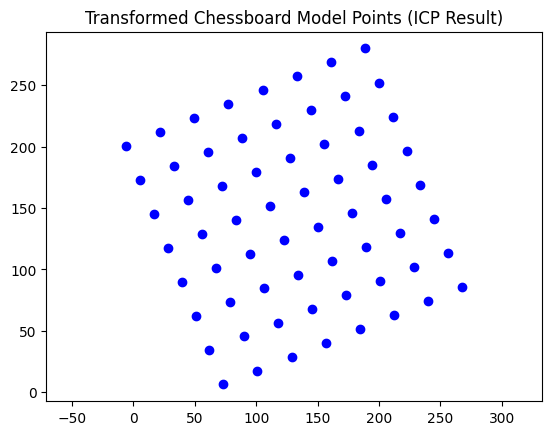

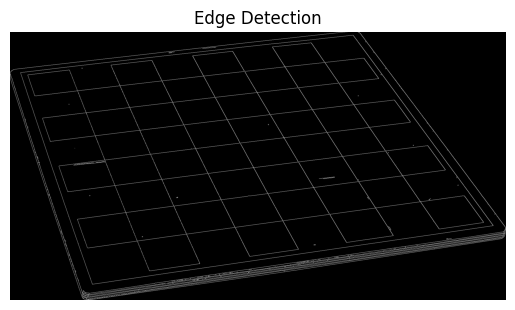

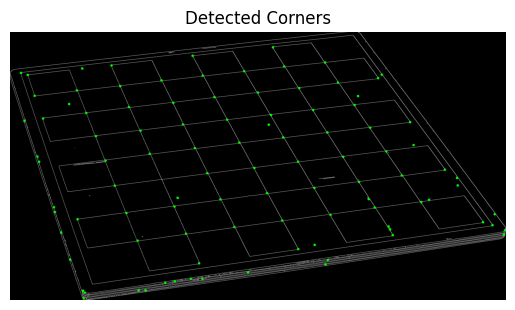

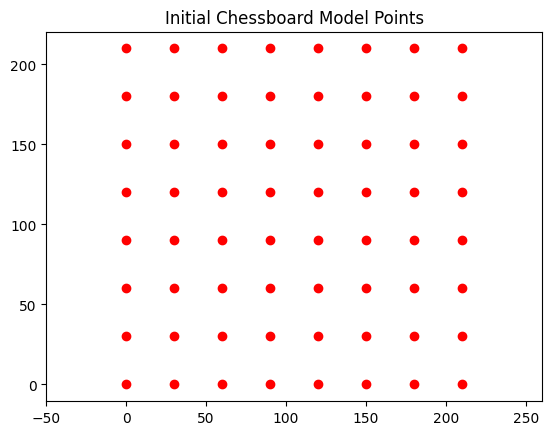

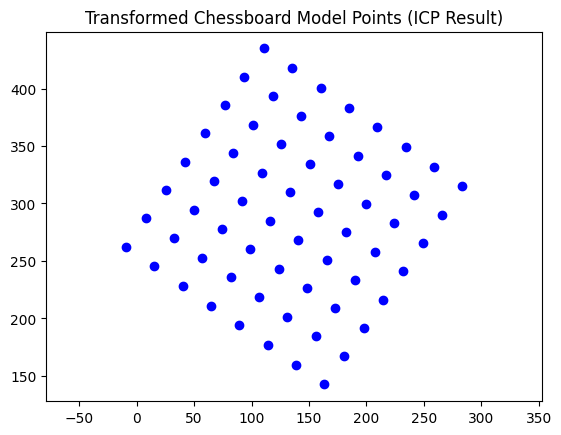

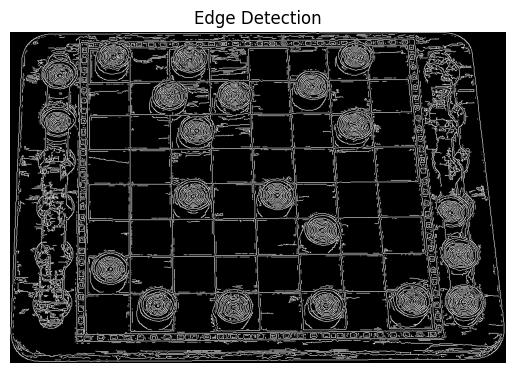

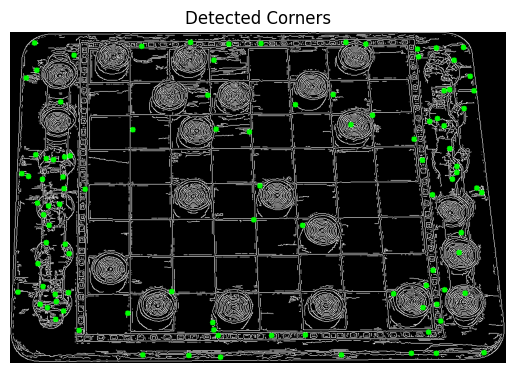

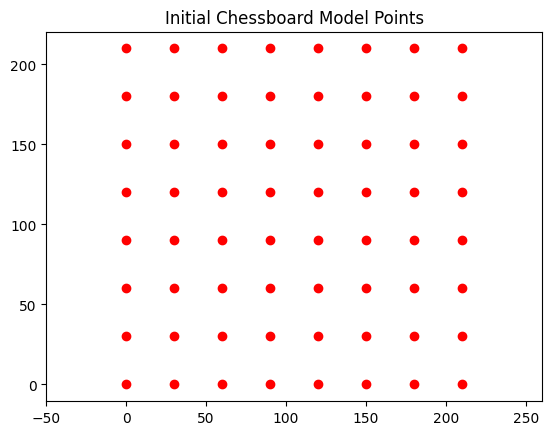

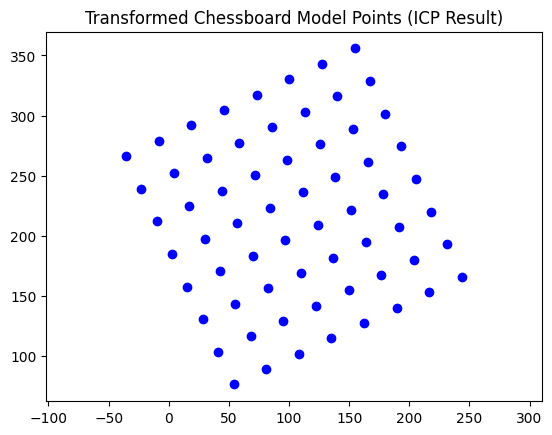

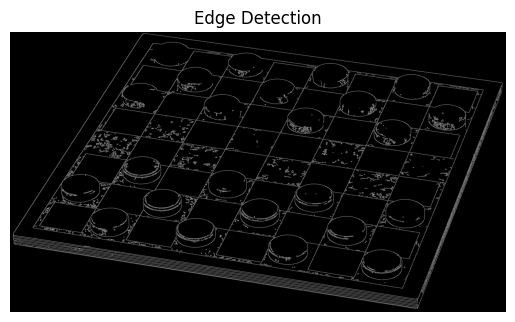

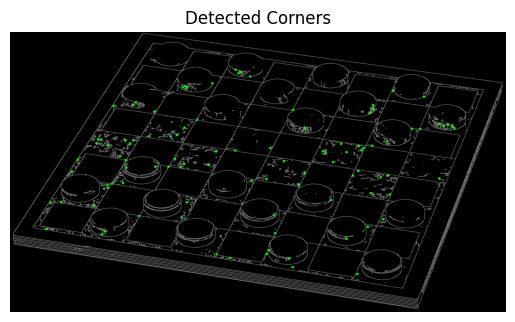

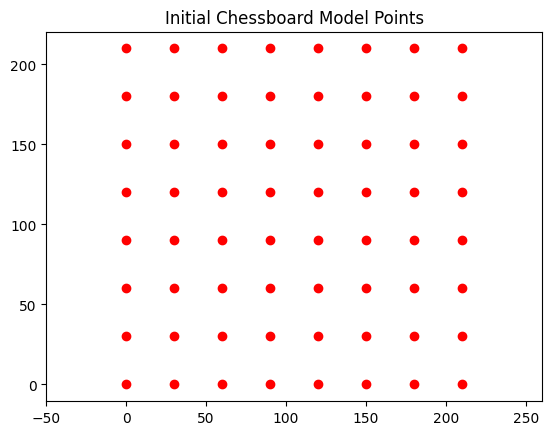

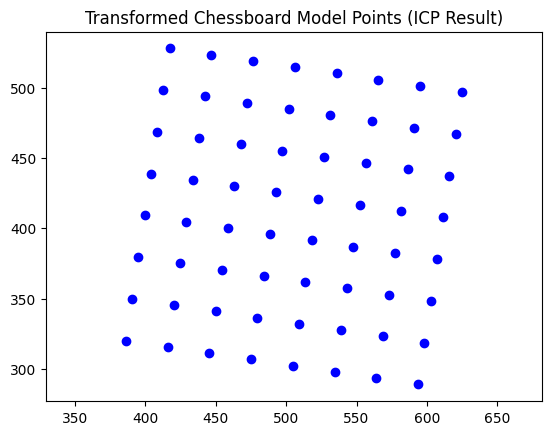

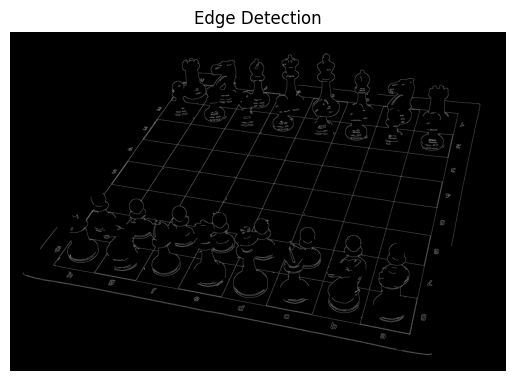

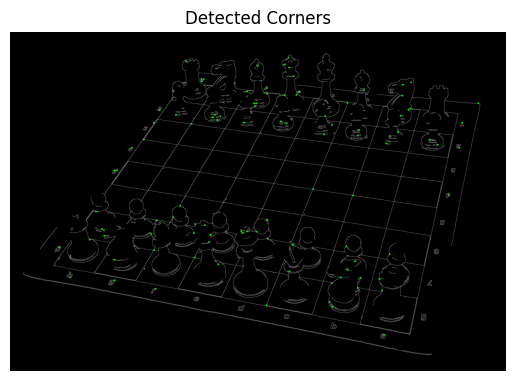

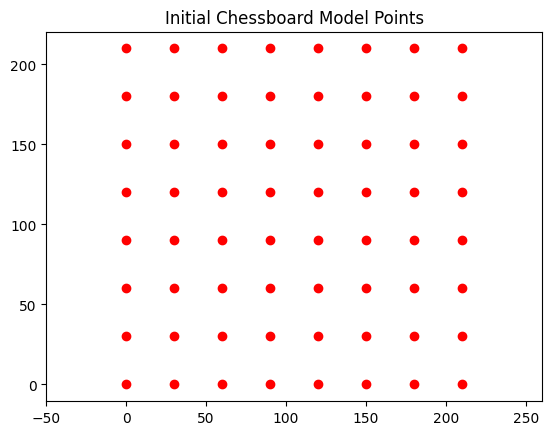

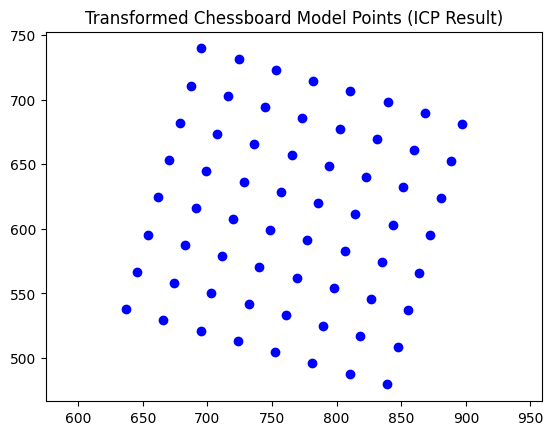

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Function to preprocess image and apply Canny edge detection
def preprocess_image(img):
    edges = cv2.Canny(img, 50, 150)
    plt.imshow(edges, cmap='gray')
    plt.title("Edge Detection")
    plt.axis('off')
    plt.show()
    return edges

# Function to detect corners using Shi-Tomasi corner detection
def detect_corners(edges):
    corners = cv2.goodFeaturesToTrack(edges, maxCorners=100, qualityLevel=0.01, minDistance=10)
    corners = np.int0(corners).reshape(-1, 2)

    # Visualize corners
    corner_img = np.dstack((edges, edges, edges))
    for corner in corners:
        cv2.circle(corner_img, tuple(corner), 5, (0, 255, 0), -1)
    
    plt.imshow(cv2.cvtColor(corner_img, cv2.COLOR_BGR2RGB))
    plt.title("Detected Corners")
    plt.axis('off')
    plt.show()
    
    return corners

# Create a synthetic chessboard model (8x8 grid, 30 pixels per square)
def create_chessboard_model(rows, cols, square_size):
    model_points = []
    for i in range(rows):
        for j in range(cols):
            model_points.append([j * square_size, i * square_size])
    return np.array(model_points)

# Function to compute the closest points and transformation matrix
def icp(source, target, iterations=50, tolerance=1e-5):
    for i in range(iterations):
        # Find closest points
        distances = np.linalg.norm(source[:, np.newaxis] - target, axis=2)
        closest_indices = np.argmin(distances, axis=1)
        closest_points = target[closest_indices]

        # Calculate centroids
        source_center = np.mean(source, axis=0)
        target_center = np.mean(closest_points, axis=0)

        # Centralize points
        source_shifted = source - source_center
        target_shifted = closest_points - target_center

        # Compute optimal rotation using Singular Value Decomposition (SVD)
        H = np.dot(source_shifted.T, target_shifted)
        U, _, Vt = np.linalg.svd(H)
        R = np.dot(Vt.T, U.T)

        # Compute translation
        t = target_center - np.dot(source_center, R)

        # Apply transformation
        source = np.dot(source, R) + t

        # Check for convergence
        mean_error = np.mean(np.linalg.norm(source - closest_points, axis=1))
        if mean_error < tolerance:
            break
    
    return source, R, t

# List of image paths
image_paths = [
    'reference_chessboard.png',
    'data/boards/reference_chessboard_pattern.jpg',
    'data/boards/black_board_difficult_corners.jpg',
    'data/boards/board_tilted.jpg',
    'data/checkerboards/checkerboard.jpg',
    'data/checkerboards/checkerboard_with_pieces_tilted.jpg',
    'data/chessboard/chessboard_with_pieces_tilted.PNG'
]

for image_path in image_paths:
    # Main process
    img = cv2.imread(os.path.relpath(image_path), cv2.IMREAD_COLOR)
    edges = preprocess_image(img)
    corners = detect_corners(edges)

    # Create a synthetic chessboard grid
    model_points = create_chessboard_model(8, 8, 30)

    # Visualize initial model points
    plt.scatter(model_points[:, 0], model_points[:, 1], c='red', marker='o')
    plt.title("Initial Chessboard Model Points")
    plt.axis('equal')
    plt.show()

    # Perform ICP
    aligned_points, R, t = icp(model_points, corners)

    print(aligned_points)

    # Visualize transformed points
    plt.scatter(aligned_points[:, 0], aligned_points[:, 1], c='blue', marker='o')
    plt.title("Transformed Chessboard Model Points (ICP Result)")
    plt.axis('equal')
    plt.show()


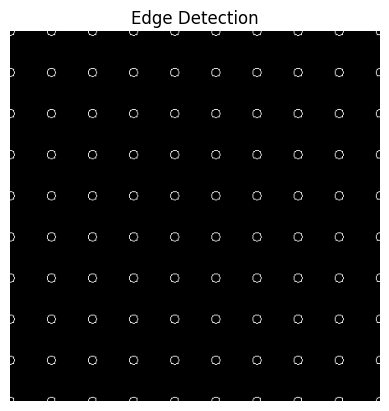

C:\Users\danim\AppData\Local\Temp\ipykernel_25180\3589832752.py:74: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  corners = np.int0(corners).reshape(-1, 2)


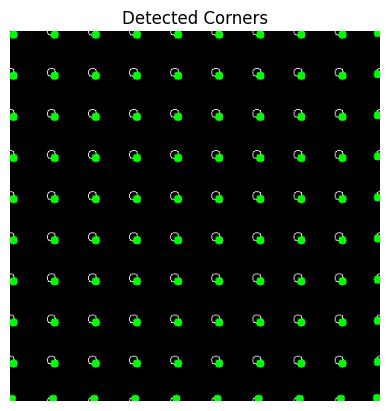

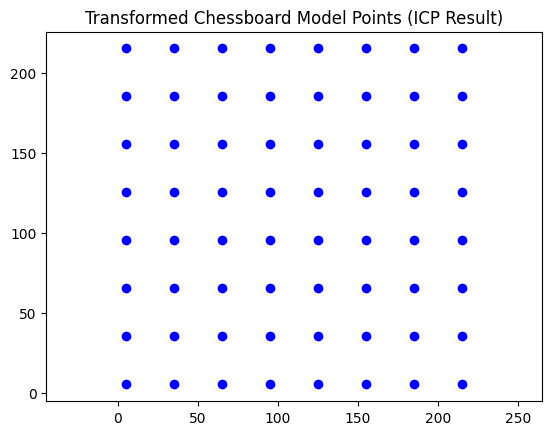

Detected Corners for Perspective Transform: [[  5.25   5.25]
 [215.25   5.25]
 [  5.25 215.25]
 [215.25 215.25]]


error: OpenCV(4.10.0) :-1: error: (-5:Bad argument) in function 'warpPerspective'
> Overload resolution failed:
>  - src is not a numpy array, neither a scalar
>  - Expected Ptr<cv::UMat> for argument 'src'


In [20]:
import cv2
"""
This script processes an image of a chessboard to detect corners, align them with a synthetic chessboard model using Iterative Closest Point (ICP) algorithm, and perform a perspective transform to obtain a bird's eye view of the chessboard.
Functions:
    preprocess_image(img):
        Preprocesses the input image and applies Canny edge detection.
        Args:
            img (numpy.ndarray): Input grayscale image.
        Returns:
            numpy.ndarray: Image with detected edges.
    detect_corners(edges):
        Detects corners in the edge-detected image using Shi-Tomasi corner detection.
        Args:
            edges (numpy.ndarray): Edge-detected image.
        Returns:
            numpy.ndarray: Array of detected corner points.
    create_chessboard_model(rows, cols, square_size):
        Creates a synthetic chessboard model with specified rows, columns, and square size.
        Args:
            rows (int): Number of rows in the chessboard.
            cols (int): Number of columns in the chessboard.
            square_size (int): Size of each square in pixels.
        Returns:
            numpy.ndarray: Array of model points representing the chessboard.
    icp(source, target, iterations=50, tolerance=1e-5):
        Performs Iterative Closest Point (ICP) algorithm to align source points to target points.
        Args:
            source (numpy.ndarray): Source points to be aligned.
            target (numpy.ndarray): Target points to align to.
            iterations (int, optional): Maximum number of iterations. Default is 50.
            tolerance (float, optional): Convergence tolerance. Default is 1e-5.
        Returns:
            tuple: Aligned source points, rotation matrix, and translation vector.
    four_point_transform(image, pts):
        Performs a perspective transform on the image using four points.
        Args:
            image (numpy.ndarray): Input image.
            pts (numpy.ndarray): Array of four points for perspective transform.
        Returns:
            PIL.Image.Image: Warped image with a bird's eye view.
    order_points(pts):
        Orders points in the correct order: top-left, top-right, bottom-right, bottom-left.
        Args:
            pts (numpy.ndarray): Array of points to be ordered.
        Returns:
            numpy.ndarray: Ordered points.
Main Process:
    1. Reads the input chessboard image.
    2. Preprocesses the image and detects edges.
    3. Detects corners in the edge-detected image.
    4. Creates a synthetic chessboard model.
    5. Aligns the model to the detected corners using ICP.
    6. Visualizes the transformed points.
    7. Applies a perspective transform to obtain a bird's eye view of the chessboard.
    8. Displays the warped image.
"""
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from numpy import asarray

# Function to preprocess image and apply Canny edge detection
def preprocess_image(img):
    edges = cv2.Canny(img, 50, 150)
    plt.imshow(edges, cmap='gray')
    plt.title("Edge Detection")
    plt.axis('off')
    plt.show()
    return edges

# Function to detect corners using Shi-Tomasi corner detection
def detect_corners(edges):
    corners = cv2.goodFeaturesToTrack(edges, maxCorners=100, qualityLevel=0.01, minDistance=10)
    corners = np.int0(corners).reshape(-1, 2)

    # Visualize corners
    corner_img = np.dstack((edges, edges, edges))
    for corner in corners:
        cv2.circle(corner_img, tuple(corner), 5, (0, 255, 0), -1)
    
    plt.imshow(cv2.cvtColor(corner_img, cv2.COLOR_BGR2RGB))
    plt.title("Detected Corners")
    plt.axis('off')
    plt.show()
    
    return corners

# Create a synthetic chessboard model (8x8 grid, 30 pixels per square)
def create_chessboard_model(rows, cols, square_size):
    model_points = []
    for i in range(rows):
        for j in range(cols):
            model_points.append([j * square_size, i * square_size])
    return np.array(model_points)

# Function to compute the closest points and transformation matrix
def icp(source, target, iterations=50, tolerance=1e-5):
    for i in range(iterations):
        # Find closest points
        distances = np.linalg.norm(source[:, np.newaxis] - target, axis=2)
        closest_indices = np.argmin(distances, axis=1)
        closest_points = target[closest_indices]

        # Calculate centroids
        source_center = np.mean(source, axis=0)
        target_center = np.mean(closest_points, axis=0)

        # Centralize points
        source_shifted = source - source_center
        target_shifted = closest_points - target_center

        # Compute optimal rotation using Singular Value Decomposition (SVD)
        H = np.dot(source_shifted.T, target_shifted)
        U, _, Vt = np.linalg.svd(H)
        R = np.dot(Vt.T, U.T)

        # Compute translation
        t = target_center - np.dot(source_center, R)

        # Apply transformation
        source = np.dot(source, R) + t

        # Check for convergence
        mean_error = np.mean(np.linalg.norm(source - closest_points, axis=1))
        if mean_error < tolerance:
            break
    
    return source, R, t

# Function to perform perspective transform using 4 points
def four_point_transform(image, pts):
    rect = order_points(pts)
    (tl, tr, br, bl) = rect

    # Compute the width of the new image
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    maxWidth = max(int(widthA), int(widthB))

    # Compute the height of the new image
    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    maxHeight = max(int(heightA), int(heightB))

    # Construct set of destination points to obtain a "birds eye view"
    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]], dtype="float32")

    # Compute the perspective transform matrix and apply it
    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))
    
    img = Image.fromarray(warped, "RGB")
    return img

# Order points to ensure they are in the correct order (top-left, top-right, bottom-right, bottom-left)
def order_points(pts):
    rect = np.zeros((4, 2), dtype="float32")
    s = pts.sum(axis=1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]
    diff = np.diff(pts, axis=1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]
    return rect

# Main process
image_path = 'reference_chessboard.png'
img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
edges = preprocess_image(img)
corners = detect_corners(edges)

# Create a synthetic chessboard grid
model_points = create_chessboard_model(8, 8, 30)

# Perform ICP to align the model to the detected corners
aligned_points, R, t = icp(model_points, corners)

# Visualize transformed points (aligned corners)
plt.scatter(aligned_points[:, 0], aligned_points[:, 1], c='blue', marker='o')
plt.title("Transformed Chessboard Model Points (ICP Result)")
plt.axis('equal')
plt.show()

# Get the four corners (top-left, top-right, bottom-right, bottom-left)
# We are assuming that the corners are the four corner points of the aligned model.
xmin, ymin = np.min(aligned_points, axis=0)
xmax, ymax = np.max(aligned_points, axis=0)
ordered_corners = np.array([[xmin, ymin], [xmax, ymin], [xmin, ymax], [xmax, ymax]])

print(f"Detected Corners for Perspective Transform: {ordered_corners}")

# Apply the perspective transform
warped_image = four_point_transform(image_path, ordered_corners)

# Show the warped image
warped_image.show()
